# Processing of the "Construction of non residentials" dataset

## Importing libraries and dataset

In [ ]:
import pandas as pd
import re
from matplotlib import pyplot as plt 
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
# pip install "folium>=0.12" matplotlib mapclassify
# pip install xlrd

# pip install keplergl


In [38]:
df = pd.read_csv("https://minio.lab.sspcloud.fr/mligeret1/constructions_non_resid_geocoded.csv",sep=",",on_bad_lines="warn")


/tmp/ipykernel_168936/724378316.py:1: DtypeWarning: Columns (1,3,5,8,12,18,20,21,22,24,30,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,108,114,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://minio.lab.sspcloud.fr/mligeret1/constructions_non_resid_geocoded.csv",sep=",",on_bad_lines="warn")


In [39]:
df.head()
df = df.iloc[1:]
df.head()



,Unnamed: 0,Code de la région du lieu des travaux - Code de la zone,Code de la région du lieu des travaux - Libellé de la zone,Code du département du lieu des travaux - Code de la zone,Code du département du lieu des travaux - Libellé de la zone,Code de la commune du lieu des travaux,"Type de DAU -- demande d'autorisation d'urbanisme (PC ou DP généralement, rarement PA)",Numéro d'enregistrement de la DAU,Etat d'avancement du projet,Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale,...,result_name,result_street,result_postcode,result_city,result_context,result_citycode,result_oldcitycode,result_oldcity,result_district,result_status
1,1,82,Rhône-Alpes,01,Ain,01001,PC,00100117V0002,5,2017-05-05,...,L'Abergement-Clémenciat,NaN,1400.0,L'Abergement-Clémenciat,"01, Ain, Auvergne-Rhône-Alpes",01001,NaN,NaN,NaN,ok
2,2,82,Rhône-Alpes,01,Ain,01001,PC,00100119V0005,2,2019-08-29,...,203 Rue des 5 Chemins,Rue des 5 Chemins,1400.0,L'Abergement-Clémenciat,"01, Ain, Auvergne-Rhône-Alpes",01001,NaN,NaN,NaN,ok
3,3,82,Rhône-Alpes,01,Ain,01001,PC,00100120V0003,5,2020-05-25,...,172 Route du Château,Route du Château,1400.0,L'Abergement-Clémenciat,"01, Ain, Auvergne-Rhône-Alpes",01001,NaN,NaN,NaN,ok
4,4,82,Rhône-Alpes,01,Ain,01001,DP,00100119V0011,2,2019-07-22,...,Chemin sous Brody,Chemin sous Brody,1400.0,L'Abergement-Clémenciat,"01, Ain, Auvergne-Rhône-Alpes",01001,NaN,NaN,NaN,ok
5,5,82,Rhône-Alpes,01,Ain,01001,DP,00100120V0011,2,2020-04-05,...,Chemin du Sorbier,Chemin du Sorbier,1400.0,L'Abergement-Clémenciat,"01, Ain, Auvergne-Rhône-Alpes",01001,NaN,NaN,NaN,ok


## TODO : Checking for errors in the geocoding
We first check if there are still some lines that were not geocoded during the batch coding (due to time-out). We send individual request to the API. 

In [40]:
df[df["result_status"] == "error"].loc[:,"Adresse_complete"]


277759                  LE VILLAGE Saint-Genies-de-Varensal
277760                   PLAISANCE Saint-Genies-de-Varensal
277761                   Plaisance Saint-Genies-de-Varensal
277762    RTE DEPARTEMENTALE 22E14 LE VILLAGE Saint-Geni...
277763    1bis RUE des Aires Hautes Saint-Genies-de-Font...
277764               RUE DES HORTS Saint-Genies-de-Fontedit
277765          RUE DE LA VICTOIRE Saint-Genies-de-Fontedit
374514         8 Rue de la Baudiniere THOUARiA_oe-SUR-LOIRE
374520              13 Rue de la BaudiniiA_oere THOUARiA_oe
374521                     rue de Milan THOUARi__-SUR-LOIRE
374522            Avenue de la Baudiniere THOUARE-SUR-LOIRE
374523                  4 Rue du Danube THOUARi_ -SUR-LOIRE
374524                  21 Rue de la Baudinii__re THOUARi__
374525      9001 Avenu du Parc des Sports THOUARE SUR LOIRE
374526                      Le Chene-Vert Thouare-sur-Loire
417855                      ZA  de la VERANGERIE Picauville
417858                    Le Coudray Hou

## Grouping columns together
Pour se faire, on regroupe les colonnes de même ordre  


In [41]:
for c in df.columns:
    print(c)

Unnamed: 0
Code de la région du lieu des travaux - Code de la zone
Code de la région du lieu des travaux - Libellé de la zone
Code du département du lieu des travaux - Code de la zone
Code du département du lieu des travaux - Libellé de la zone
Code de la commune du lieu des travaux
Type de DAU -- demande d'autorisation d'urbanisme (PC ou DP généralement, rarement PA)
Numéro d'enregistrement de la DAU
Etat d'avancement du projet
Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale
Date réelle d'ouverture de chantier
Date réelle d'achèvement des travaux
Année de dépôt de la DAU
Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)
Date (mois) de prise en compte (DPC) de l'autorisation initiale
Date (mois) de prise en compte (DPC) de l'ouverture du chantier
Date (mois) (DPC) de dernière mise à jour des données
Code d'activité principale de l'établissement d'un demandeur avéré en tant que personne morale
Catégorie j

In [42]:
col_metadata = [x for x in df.columns if "DAU" in x] + ["Unnamed: 0"]
col_meta_location = [x for x in df.columns if "lieu des travaux" in x]
col_dates_travaux = [x for x in df.columns if "Date" in x]
col_demandeurs = [x for x in df.columns if "demandeur" in x and ("Nature du projet déclarée par le demandeur" not in x)]
col_precise_location = [x for x in df.columns if "du terrain" in x and ("Superficie du terrain" not in x)] 
col_cadastres = [x for x in df.columns if "cadastre" in x]
col_construction_details = [x for x in df.columns if "Indicateur" in x] + ["Nombre de niveaux du bâtiment le plus élevé","Nombre de chambres (hôtels et autres hébergements, notamment sociaux)"]
col_details_transf = [x for x in df.columns if "Surface de plancher" in x]
col_from_geocodage = [i for i in df.columns if "result_" in i]

col_irrelevant = col_metadata + col_dates_travaux + col_precise_location + col_cadastres + col_construction_details + col_details_transf + col_from_geocodage
col_relevant =  [c for c in df.columns if c not in col_irrelevant] 
for c in col_relevant:
    print(c)

Code de la région du lieu des travaux - Code de la zone
Code de la région du lieu des travaux - Libellé de la zone
Code du département du lieu des travaux - Code de la zone
Code du département du lieu des travaux - Libellé de la zone
Code de la commune du lieu des travaux
Etat d'avancement du projet
Code d'activité principale de l'établissement d'un demandeur avéré en tant que personne morale
Catégorie juridique d'un demandeur avéré en tant que personne morale
Dénomination d'un demandeur avéré en tant que personne morale
Numéro SIREN d'un demandeur avéré en tant que personne morale
Numéro SIRET d'un demandeur avéré en tant que personne morale
Code postal du demandeur
Localité du demandeur
Superficie du terrain
Code zone opératoire
Nature du projet déclarée par le demandeur
Nature de projet détaillée
Destination principale
Type principal de transformation
Type principal des locaux d'origine transformés
Type de service public ou d'intérêt collectif
Adresse_complete
longitude
latitude


In [43]:
df.loc[:,col_relevant].sample(50)



,Code de la région du lieu des travaux - Code de la zone,Code de la région du lieu des travaux - Libellé de la zone,Code du département du lieu des travaux - Code de la zone,Code du département du lieu des travaux - Libellé de la zone,Code de la commune du lieu des travaux,Etat d'avancement du projet,Code d'activité principale de l'établissement d'un demandeur avéré en tant que personne morale,Catégorie juridique d'un demandeur avéré en tant que personne morale,Dénomination d'un demandeur avéré en tant que personne morale,Numéro SIREN d'un demandeur avéré en tant que personne morale,...,Code zone opératoire,Nature du projet déclarée par le demandeur,Nature de projet détaillée,Destination principale,Type principal de transformation,Type principal des locaux d'origine transformés,Type de service public ou d'intérêt collectif,Adresse_complete,longitude,latitude
783224,4,La Réunion,974,La Réunion,97416,2,49.31Z,5710.0,CHARLES EXPRESS,342167194.0,...,4,1,1,3,NaN,NaN,7,Rue Maxime Riviere Ravine des Cafres Saint-Pierre,55.518009,-21.337252
592577,26,Bourgogne,71,Saône-et-Loire,71169,5,84.12Z,7353.0,SIVOS DE DAVAYE VERGISSON,257102533.0,...,4,1,1,9,NaN,NaN,2,139 rue du Moulin de l'Etang DAVAYE,4.746733,46.302511
49023,21,Champagne-Ardenne,10,Aube,10340,5,68.20B,6540.0,LES CABANES DE NORAH,893284174.0,...,4,1,1,9,NaN,NaN,3,7 rue des Cerisiers SAINT-GERMAIN,4.031624,48.255526
19940,93,Provence-Alpes-Côte d'Azur,4,Alpes-de-Haute-Provence,4112,2,20.42Z,5599.0,L'OCCITANE - MELVITA - M&L - AHP- ERBORIAN,305823296.0,...,4,2,5,8,NaN,NaN,7,Chemin Saint Maurice MANOSQUE,5.812341,43.797579
346034,82,Rhône-Alpes,42,Loire,42159,2,68.20A,5710.0,JULCHLO,891130700.0,...,4,2,5,4,NaN,NaN,7,12 Rue de l'Aubepine NOIRETABLE,3.764880,45.822559
87283,93,Provence-Alpes-Côte d'Azur,13,Bouches-du-Rhône,13117,5,45.20B,5710.0,3 P TRUCK SERVICES,791236078.0,...,4,2,5,3,NaN,NaN,7,24/26 AV DE BRUXELLES Z.I DES ESTROUBLANS VITR...,5.241606,43.426132
325226,43,Franche-Comté,39,Jura,39300,5,86.10Z,7364.0,CENTRE HOSPITALIER JURA-SUD,263900052.0,...,4,2,5,9,NaN,NaN,3,55 RUE DU DOCTEUR JEAN MICHEL LONS-LE-SAUNIER,5.552379,46.676792
356724,52,Pays de la Loire,44,Loire-Atlantique,44003,2,94.99Z,9220.0,UNE FAMILLE UN TOIT 44,411753890.0,...,4,2,5,2,NaN,NaN,7,735 boule MADAME DE SEVIGNE ANCENIS-SAINT-GEREON,-1.190081,47.378152
268210,91,Languedoc-Roussillon,34,Hérault,34010,2,NaN,NaN,NaN,NaN,...,4,2,2,1,3.0,1.0,7,39 BOULEVARD SAINT JEAN ANIANE,3.584907,43.685085
65304,93,Provence-Alpes-Côte d'Azur,13,Bouches-du-Rhône,13001,6,68.20B,6540.0,SCI AIX LESSEPS ET TUBINGEN,821819836.0,...,4,1,1,1,NaN,NaN,7,6 BD FERDINAND DE LESSEPS AIX EN PROVENCE,5.435979,43.525288


In [44]:
plt.figure(figsize=(20,10))

#sns.heatmap(df.isna(), cbar=False)


<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

#### **REACTIVER A LA FIN, DESACTIVER TEMPORAIREMENT**

def identification_usage(ligne):
    col_max = ligne.iloc[len(dates_lieux_travaux):].idxmax()
    pattern = r"Surface de plancher de la destination (.+?) (nouvelle construite|issue d'une transformation)$"

    match = re.search(pattern, col_max, re.IGNORECASE)
    print("Testing column:", repr(col_max))
    return match.group(1) if match else None

df_usage = df.loc[:,colonnes_pertinentes].sample(1000)
df_usage["Destination du lieu"]= df_usage.apply(identification_usage, axis = 1)



## Arranging columns types 


In [45]:
dico_variables = pd.read_excel("https://minio.lab.sspcloud.fr/mligeret1/dictionnaire-variables-locaux-permis-construire-20220531.xls")

In [46]:
dico_variables.head()


,Nom de la variable,Description de la variable,Nouveau mai 2022?,Modalités,Format,Observations,Origine
0,REG,Code de la région du lieu des travaux,NaN,Nomenclature du Code Officiel Géographique (CO...,"Alphanumérique, 2 caractères",NaN,Numéro d'enregistrement de la DAU
1,DEP,Code du département du lieu des travaux,NaN,NaN,"Alphanumérique, 2 caractères",NaN,Numéro d'enregistrement de la DAU
2,COMM,Code de la commune du lieu des travaux,NaN,Nomenclature du Code Officiel Géographique (CO...,"Alphanumérique, 5 caractères",Le code vient directement du numéro d'enregist...,Numéro d'enregistrement de la DAU
3,Type_DAU,Type de DAU -- demande d'autorisation d'urbani...,NaN,PC (Permis de construire)\nDP (Déclaration Pré...,"Alphanumérique, 2 caractères",NaN,Numéro d'enregistrement de la DAU
4,Num_DAU,Numéro d'enregistrement de la DAU,NaN,NaN,"Alphanumérique, 13 caractères",Numéro sur 13 caractères : les 6 premiers cara...,Numéro d'enregistrement de la DAU


### Retrouver depuis le dictionnaire 

In [47]:
def variable_types(ligne):
    if ("Année" in ligne["Description de la variable"]):
        return None
    if "Alphanumérique" in ligne["Format"]:
        return "string"
    if "Numérique" in ligne["Format"]:
        return "Int64"
        
dico_variables["Format_python"] = dico_variables.apply(variable_types, axis=1)


In [48]:
dtype_map = dict(zip(dico_variables["Description de la variable"], dico_variables["Format_python"]))
dtype_map = {col : python_type for col, python_type in dtype_map.items() if col in df.columns}
df = df.astype(dtype_map, errors="ignore")


In [49]:
df.dtypes.to_frame().style

,0
Unnamed: 0,int64
Code de la région du lieu des travaux - Code de la zone,object
Code de la région du lieu des travaux - Libellé de la zone,object
Code du département du lieu des travaux - Code de la zone,object
Code du département du lieu des travaux - Libellé de la zone,object
Code de la commune du lieu des travaux,string
"Type de DAU -- demande d'autorisation d'urbanisme (PC ou DP généralement, rarement PA)",string
Numéro d'enregistrement de la DAU,string
Etat d'avancement du projet,string
Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale,object


### Régler la question de la date 

In [50]:
df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"].value_counts().to_frame().style #to verify that dates are well specified under the format %Y%m, i.e. year with 4 digits followed by month
df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"] = pd.to_datetime(df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"], format="%Y-%m", errors="coerce")


We repeat the operation for the other columns that involve date/year dtypes


In [51]:
for col_date in col_dates_travaux:
    print(df[col_date].value_counts().to_frame()) #to verify the format of the date

                                                    count
Date réelle d'autorisation (PC) ou de non-oppos...       
2013-02-28                                            464
2013-03-21                                            430
2013-06-27                                            413
2013-03-28                                            409
2013-06-21                                            394
...                                                   ...
2020-06-21                                              2
2024-03-31                                              2
2020-04-11                                              2
2025-09-09                                              2
2025-09-10                                              1

[4634 rows x 1 columns]
                                     count
Date réelle d'ouverture de chantier       
2014-09-01                             749
2015-09-01                             632
2020-09-01                             620
2018-1

In [52]:
col_date_format_ymd = [col_dates_travaux[i] for i in [0,1,2,3]]
col_date_format_ym = [col_dates_travaux[i] for i in [4,5,6]]

In [53]:
for col in col_date_format_ymd:
    print(df[col])
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d")



1         2017-05-05
2         2019-08-29
3         2020-05-25
4         2019-07-22
5         2020-04-05
             ...    
786734    2022-04-02
786735    2022-11-25
786736    2023-01-01
786737    2023-11-23
786738    2025-08-22
Name: Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale, Length: 786738, dtype: object
1         2017-06-01
2                NaN
3         2024-07-08
4                NaN
5                NaN
             ...    
786734           NaN
786735           NaN
786736           NaN
786737           NaN
786738           NaN
Name: Date réelle d'ouverture de chantier, Length: 786738, dtype: object
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
         ... 
786734    NaN
786735    NaN
786736    NaN
786737    NaN
786738    NaN
Name: Date réelle d'achèvement des travaux, Length: 786738, dtype: object
1        2017-02-01
2        2019-07-01
3        2020-05-01
4        2019-07-01
5        2020-03-01
            ...    
786734   2022

In [54]:
for col in col_date_format_ym:
    print(df[col])
    df[col] = pd.to_datetime(df[col], format="%Y-%m")


1         2017-05
2         2019-09
3         2021-09
4         2019-07
5         2020-04
           ...   
786734    2022-04
786735    2022-11
786736    2023-01
786737    2023-11
786738    2025-08
Name: Date (mois) de prise en compte (DPC) de l'autorisation initiale, Length: 786738, dtype: object
1         2018-02
2             NaN
3         2024-07
4             NaN
5             NaN
           ...   
786734        NaN
786735        NaN
786736        NaN
786737        NaN
786738        NaN
Name: Date (mois) de prise en compte (DPC) de l'ouverture du chantier, Length: 786738, dtype: object
1         2018-02
2         2019-09
3         2024-07
4         2019-07
5         2020-04
           ...   
786734    2022-04
786735    2022-11
786736    2023-01
786737    2023-11
786738    2025-08
Name: Date (mois) (DPC) de dernière mise à jour des données, Length: 786738, dtype: object


In [55]:
col = "Année de dépôt de la DAU"
print(df[col])
df[col] = df[col].astype("int64")

1         2017
2         2019
3         2020
4         2019
5         2020
          ... 
786734    2022
786735    2022
786736    2022
786737    2023
786738    2025
Name: Année de dépôt de la DAU, Length: 786738, dtype: object


### Compléter les dernières colonnes

In [56]:
df = df.astype({col : "float64" for col in col_details_transf + ["Superficie du terrain"]})

df = df.astype({col : "string" for col in col_meta_location + col_cadastres + ["Code zone opératoire"]})
df = df.astype({col : "string" for col in ["Adresse_complete"]})


In [57]:
df.dtypes.to_frame().style

,0
Unnamed: 0,int64
Code de la région du lieu des travaux - Code de la zone,string
Code de la région du lieu des travaux - Libellé de la zone,string
Code du département du lieu des travaux - Code de la zone,string
Code du département du lieu des travaux - Libellé de la zone,string
Code de la commune du lieu des travaux,string
"Type de DAU -- demande d'autorisation d'urbanisme (PC ou DP généralement, rarement PA)",string
Numéro d'enregistrement de la DAU,string
Etat d'avancement du projet,string
Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale,datetime64[ns]


## Cleaning per column



### Cleaning dates 

In [58]:
df.loc[:,col_dates_travaux].sample(20)


,Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale,Date réelle d'ouverture de chantier,Date réelle d'achèvement des travaux,Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation),Date (mois) de prise en compte (DPC) de l'autorisation initiale,Date (mois) de prise en compte (DPC) de l'ouverture du chantier,Date (mois) (DPC) de dernière mise à jour des données
198564,2019-10-08,2020-03-09,2022-02-08,2019-07-01,2019-10-01,2020-03-01,2022-03-01
213675,2021-10-07,2022-04-01,2023-01-31,2021-06-01,2021-10-01,2022-09-01,2023-07-01
412659,2013-09-09,NaT,NaT,2013-07-01,2013-09-01,NaT,2013-09-01
282631,2018-01-31,2018-05-22,2019-06-20,2017-12-01,2018-02-01,2018-05-01,2019-07-01
599244,2024-06-14,2025-07-28,NaT,2024-04-01,2025-01-01,2025-07-01,2025-07-01
104721,2017-11-10,NaT,NaT,2018-04-01,2018-04-01,NaT,2018-04-01
640570,2024-03-28,NaT,NaT,2024-02-01,2024-03-01,NaT,2024-03-01
581330,2023-06-02,NaT,NaT,2022-09-01,2023-06-01,NaT,2023-06-01
199588,2019-12-06,NaT,NaT,2019-07-01,2019-12-01,NaT,2019-12-01
460647,2017-07-06,2017-10-01,NaT,2017-07-01,2017-07-01,2017-10-01,2017-10-01


On regarde si les dates mis à part la colonne des années sont cohérentes, ce qui semble être le cas 

In [59]:
df[df[col_dates_travaux].gt(pd.Timestamp.today()).any(axis=1)][col_dates_travaux+["Année de dépôt de la DAU"]].head(20)


,Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale,Date réelle d'ouverture de chantier,Date réelle d'achèvement des travaux,Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation),Date (mois) de prise en compte (DPC) de l'autorisation initiale,Date (mois) de prise en compte (DPC) de l'ouverture du chantier,Date (mois) (DPC) de dernière mise à jour des données,Année de dépôt de la DAU


In [60]:
df[df["Année de dépôt de la DAU"]>2025][col_dates_travaux+["Année de dépôt de la DAU"]].head(20)


,Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale,Date réelle d'ouverture de chantier,Date réelle d'achèvement des travaux,Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation),Date (mois) de prise en compte (DPC) de l'autorisation initiale,Date (mois) de prise en compte (DPC) de l'ouverture du chantier,Date (mois) (DPC) de dernière mise à jour des données,Année de dépôt de la DAU
84573,2014-06-13,NaT,NaT,2014-06-01,2014-06-01,NaT,2014-06-01,2095
658764,2013-05-23,2013-06-23,2013-09-23,2013-05-01,2013-05-01,2013-10-01,2013-10-01,2087
689837,2014-12-15,NaT,NaT,2014-12-01,2014-12-01,NaT,2014-12-01,2099
758694,2013-05-15,2013-05-15,2013-07-12,2013-05-01,2013-05-01,2014-05-01,2014-05-01,2090
773552,2013-08-02,NaT,NaT,2013-07-01,2013-07-01,NaT,2013-09-01,2093


In [61]:
ligns_gt_today = df["Année de dépôt de la DAU"]>2025
df.loc[ligns_gt_today,"Année de dépôt de la DAU"] = df.loc[ligns_gt_today,"Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"].dt.year

In [62]:
df[df["Année de dépôt de la DAU"]>2025][col_dates_travaux+["Année de dépôt de la DAU"]].head(20)


,Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale,Date réelle d'ouverture de chantier,Date réelle d'achèvement des travaux,Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation),Date (mois) de prise en compte (DPC) de l'autorisation initiale,Date (mois) de prise en compte (DPC) de l'ouverture du chantier,Date (mois) (DPC) de dernière mise à jour des données,Année de dépôt de la DAU


On cherche à voir les années avant lesquelles il y a peu de données et qu'il vaut mieux supprimer pour l'analyse statistique 

<Axes: xlabel='Année de dépôt de la DAU'>

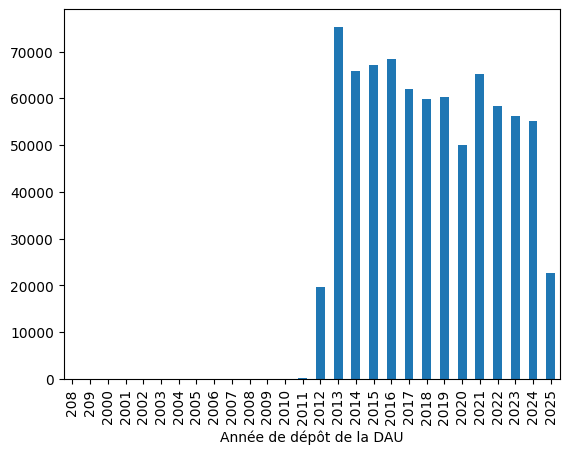

In [63]:
df["Année de dépôt de la DAU"].value_counts().sort_index().plot.bar()


On peut supprimer tout ce qui vient avant 2012, 2012 compris ainsi que l'année 2025 qui est en cours 

In [64]:
ligns_few_values = (df["Année de dépôt de la DAU"]<=2012) | (df["Année de dépôt de la DAU"] == 2025)
df = df.drop(df.index[ligns_few_values])

<Axes: xlabel='Année de dépôt de la DAU'>

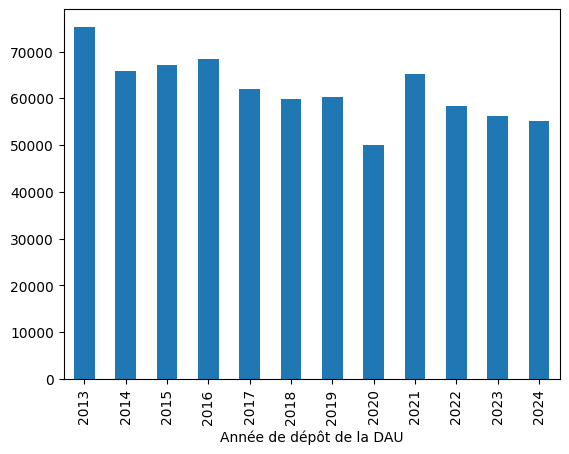

In [65]:
df["Année de dépôt de la DAU"].value_counts().sort_index().plot.bar()


### Cleaning Departments 

In [ ]:
df["Code du département du lieu des travaux - Code de la zone"].nunique()

102

On remarque que le département 2 et 02 est codé deux fois, on vérifie que c'est bien le même département, puis on renomme 2 en 02, de même pour les autres départements, cela permettra d'avoir des séries bien ordonnées dans l'ordre

In [80]:
df.loc[(df["Code du département du lieu des travaux - Code de la zone"]=="2") | (df["Code du département du lieu des travaux - Code de la zone"]=="02"), col_meta_location].sample(10)

,Code de la région du lieu des travaux - Code de la zone,Code de la région du lieu des travaux - Libellé de la zone,Code du département du lieu des travaux - Code de la zone,Code du département du lieu des travaux - Libellé de la zone,Code de la commune du lieu des travaux
9991,22,Picardie,2,Aisne,2360
11228,22,Picardie,2,Aisne,2589
12755,22,Picardie,2,Aisne,2807
11934,22,Picardie,2,Aisne,2691
12558,22,Picardie,2,Aisne,2770
11719,22,Picardie,2,Aisne,2691
9035,22,Picardie,2,Aisne,2173
9071,22,Picardie,2,Aisne,2173
11932,22,Picardie,2,Aisne,2691
12587,22,Picardie,2,Aisne,2778


In [85]:
df.loc[df["Code du département du lieu des travaux - Code de la zone"].str.len()==1,"Code du département du lieu des travaux - Code de la zone"] 

8192     2
8193     2
8194     2
8195     2
8196     2
        ..
45885    9
45886    9
45887    9
45888    9
45889    9
Name: Code du département du lieu des travaux - Code de la zone, Length: 35768, dtype: string

In [104]:
df["Code du département du lieu des travaux - Code de la zone"]=df["Code du département du lieu des travaux - Code de la zone"].str.zfill(2)

### Isolating overseas departments (DOM)

In [ ]:
df_dom = df.loc[df["Code du département du lieu des travaux - Code de la zone"].str.startswith("97")] 
df = df.drop(df_dom.index)

In [ ]:
df_dom.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(0).sort_index().plot()


KeyError: 'Année de dépôt de la DAU'

### Replacing qualitative numeric value by its name 

In [ ]:
destinations = [
    "habitation",
    "hébergement hôtelier",
    "bureaux",
    "commerce",
    "artisanat",
    "industrie",
    "agriculture",
    "entrepôt",
    "service public ou d'intérêt collectif"
]

dict_destination_principale = {key: value for key, value in zip(range(1, 10), destinations)}


{1: 'habitation',
 2: 'hébergement hôtelier',
 3: 'bureaux',
 4: 'commerce',
 5: 'artisanat',
 6: 'industrie',
 7: 'agriculture',
 8: 'entrepôt',
 9: "service public ou d'intérêt collectif"}

In [165]:
df.loc[~df["Destination principale"].isin(range(1, 10)),"Destination principale"]

Series([], Name: Destination principale, dtype: Int64)

In [170]:

df["Destination principale"] = pd.to_numeric(df["Destination principale"],errors="coerce")
df["Destination principale"] = df["Destination principale"].apply(lambda x : dict_destination_principale[x])


## First descriptive statistics 

### Main usage of the building before and after 

In [85]:
df["Destination principale"].value_counts()

Destination principale
7    165977
9    157836
1    129660
4     84580
8     82167
3     65829
6     44744
5     43730
2     12215
Name: count, dtype: Int64

In [86]:
df["Type principal des locaux d'origine transformés"].value_counts()

Type principal des locaux d'origine transformés
1.0    49456
4.0    17054
8.0    13608
3.0    12599
9.0     9594
7.0     8754
5.0     5218
6.0     3077
2.0     1713
1        382
8        151
7        137
4        128
5         95
9         89
3         64
6         50
2         20
Name: count, dtype: Int64

### Construction Activity Time Series

<Axes: xlabel='Année de dépôt de la DAU'>

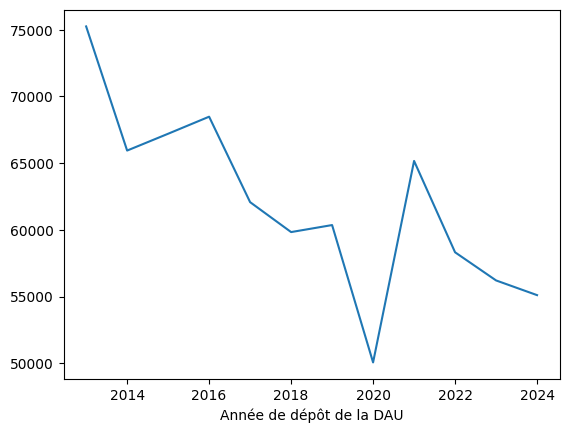

In [92]:
df["Année de dépôt de la DAU"].value_counts().sort_index().plot()


In [91]:
df["Date"] = df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"]


In [112]:
df[df["Date"].dt.year<=2012][col_dates_travaux+["Année de dépôt de la DAU"]]


,Date réelle d'autorisation (PC) ou de non-opposition (DP) initiale,Date réelle d'ouverture de chantier,Date réelle d'achèvement des travaux,Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation),Date (mois) de prise en compte (DPC) de l'autorisation initiale,Date (mois) de prise en compte (DPC) de l'ouverture du chantier,Date (mois) (DPC) de dernière mise à jour des données,Année de dépôt de la DAU
30178,2013-01-31,NaT,NaT,2012-12-01,2013-01-01,NaT,2013-01-01,2013
73646,2013-05-07,NaT,NaT,2012-12-01,2013-05-01,NaT,2013-05-01,2013
73794,2013-01-31,NaT,NaT,2012-12-01,2013-01-01,NaT,2013-01-01,2013
79154,2013-04-19,2013-09-02,NaT,2012-12-01,2013-05-01,2013-09-01,2013-09-01,2013
117421,2013-04-03,NaT,NaT,2012-12-01,2013-08-01,NaT,2013-08-01,2013
218045,2013-03-04,NaT,NaT,2012-07-01,2013-03-01,NaT,2013-03-01,2013
301558,2020-09-16,NaT,NaT,2010-04-01,2020-09-01,NaT,2020-09-01,2020
379017,2013-01-30,NaT,NaT,2012-12-01,2013-10-01,NaT,2013-10-01,2013
513117,2013-02-25,NaT,NaT,2012-12-01,2013-02-01,NaT,2013-02-01,2013
515246,2013-01-29,NaT,NaT,2012-12-01,2013-01-01,NaT,2013-01-01,2013


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.2000e+01, 2.2801e+04, 3.1370e+04, 2.3258e+04,
        2.9670e+04, 2.5239e+04, 2.1596e+04, 2.8572e+04, 2.1692e+04,
        3.0541e+04, 2.6886e+04, 2.1961e+04, 2.8101e+04, 1.8449e+04,
        2.5998e+04, 2.4667e+04, 1.9349e+04, 2.6288e+04, 1.9581e+04,
        2.3508e+04, 1.9601e+04, 1.7273e+04, 2.6418e+04, 2.1719e+04,
        2.5934e+04, 2.7650e+04, 1.6783e+04, 2.5035e+04, 1.9224e+04,
        2.2291e+04, 2.4258e+04, 1.7570e+04, 1.0374e+04, 2.9400e+02]),
 array([14700.   , 14840.025, 14980.05 , 15120.075, 15260.1  , 15400.125,
        15540.15 , 15680.175, 15820.2  , 15960.225, 16100.25 , 16240.275,
        16380.3  , 16520.325, 16660.35 , 16800.375, 16940.4  , 17080.425,
        17220.45 , 17360.475, 17500.5  , 17640.525, 17780.55 , 17920.575,
        18060.6  , 18200.625, 18340.65 , 18480.675, 18620.7  , 18760.725,
        18900.75 , 19040.775, 19180.8  , 19320.825, 19460.85 , 19600.875,
        19

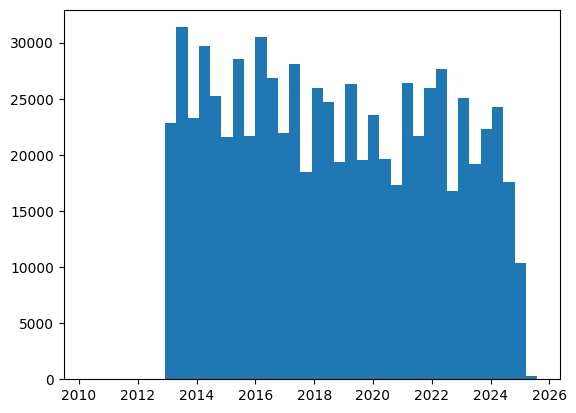

In [108]:
plt.hist(df["Date"], bins=40)    


### Question : In which departments did we build the most ? 

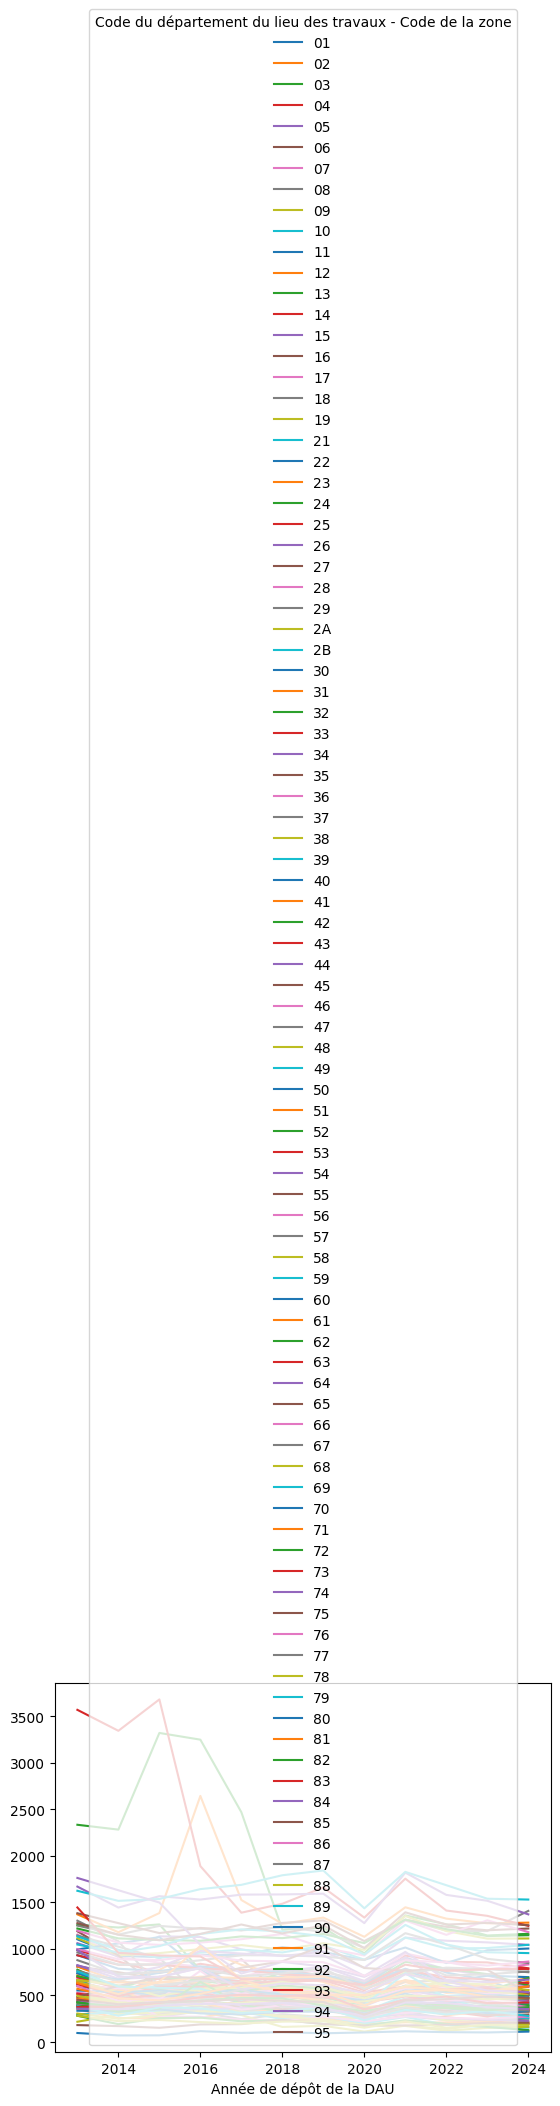

In [122]:
activity_per_department = df.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(0).sort_index().plot()


array([[<Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>],
       [<Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année d

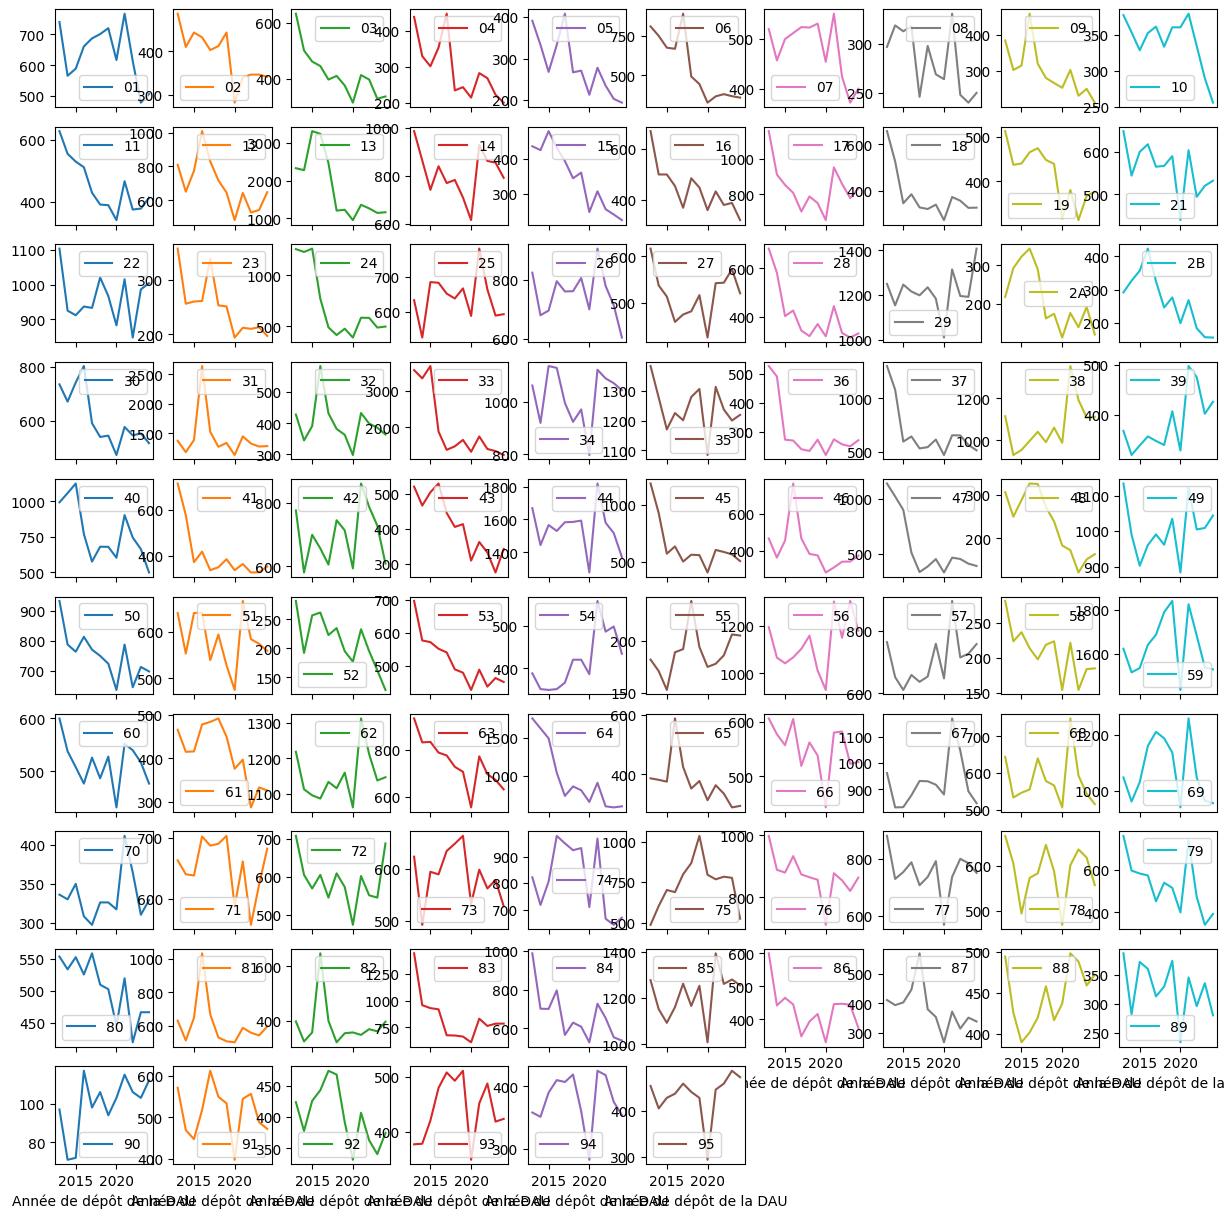

In [125]:
df.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(0).sort_index().plot(
    subplots=True,
    layout=(10,10),
    figsize=(15,15),
    legend=True 
)


In [111]:
activity_per_department = df.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(1)
activity_per_department.head(50)

Année de dépôt de la DAU,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Code du département du lieu des travaux - Code de la zone,,,,,,,,,,,,
01,740,566,589,661,687,701,720,617,767,614,479,507
02,486,410,443,432,403,412,443,283,341,347,347,342
03,632,501,462,446,398,411,377,316,414,398,330,338
04,438,329,301,353,447,234,243,214,282,268,222,200
05,391,333,268,333,408,267,271,213,278,235,203,194
06,810,750,675,668,891,492,444,326,366,380,367,358
07,520,457,500,512,524,523,531,454,551,424,372,400
08,297,319,313,318,246,298,269,264,331,248,240,250
09,384,303,315,458,320,281,267,254,303,232,251,213


It's not very convenient to read and analyze, let's try making it clearer 

Let's first determine for a given year, in which departments did we build the most 
#### Q1 : For the year 2018, in which department did we build the most ? 

In [ ]:
construction_activity2018 = activity_per_department[2018].sort_values().reset_index()

In [130]:
construction_activity2018.nunique()

Code du département du lieu des travaux - Code de la zone    96
2018                                                         93
dtype: int64

#### -> Q1 : TODO There are some departments where nothing was built ... 

In [121]:
construction_activity2018["Code du département du lieu des travaux - Code de la zone"].nunique()

96

In [131]:
construction_activity2018.loc[construction_activity2018[2018]==None]

,Code du département du lieu des travaux - Code de la zone,2018


#### -> Q1 : Let's represent departments on a map 

In [133]:
deps = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson")

In [134]:
deps.index = deps.index.astype(str).str.zfill(2)
deps.head(50)


,code,nom,geometry
00,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
01,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
02,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3..."
03,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
04,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."
05,06,Alpes-Maritimes,"MULTIPOLYGON (((7.06711 43.51365, 7.06665 43.5..."
06,2A,Corse-du-Sud,"MULTIPOLYGON (((8.5864 41.87389, 8.58667 41.87..."
07,2B,Haute-Corse,"MULTIPOLYGON (((9.40875 43.02232, 9.40662 43.0..."
08,07,Ardèche,"POLYGON ((4.48313 45.23645, 4.4879 45.23218, 4..."
09,08,Ardennes,"POLYGON ((4.23316 49.95775, 4.2369 49.95858, 4..."


In [146]:
construction_activity2018 = construction_activity2018.merge(
    deps,
    left_on="Code du département du lieu des travaux - Code de la zone",
    right_on="code",
    how="left"
)

construction_activity2018.head(50)


,Code du département du lieu des travaux - Code de la zone,2018,code_x,nom_x,geometry_x,code_y,nom_y,geometry_y,code,nom,geometry
0,90,106,90,Territoire de Belfort,"POLYGON ((6.82354 47.81305, 6.82384 47.81426, ...",90,Territoire de Belfort,"POLYGON ((6.82354 47.81305, 6.82384 47.81426, ...",90,Territoire de Belfort,"POLYGON ((6.82354 47.81305, 6.82384 47.81426, ..."
1,2A,162,2A,Corse-du-Sud,"MULTIPOLYGON (((8.5864 41.87389, 8.58667 41.87...",2A,Corse-du-Sud,"MULTIPOLYGON (((8.5864 41.87389, 8.58667 41.87...",2A,Corse-du-Sud,"MULTIPOLYGON (((8.5864 41.87389, 8.58667 41.87..."
2,58,219,58,Nièvre,"POLYGON ((2.87463 47.52042, 2.87074 47.52314, ...",58,Nièvre,"POLYGON ((2.87463 47.52042, 2.87074 47.52314, ...",58,Nièvre,"POLYGON ((2.87463 47.52042, 2.87074 47.52314, ..."
3,04,234,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,52,235,52,Haute-Marne,"POLYGON ((4.67018 48.53189, 4.67374 48.53396, ...",52,Haute-Marne,"POLYGON ((4.67018 48.53189, 4.67374 48.53396, ...",52,Haute-Marne,"POLYGON ((4.67018 48.53189, 4.67374 48.53396, ..."
5,36,235,36,Indre,"POLYGON ((1.32667 47.18623, 1.33849 47.19554, ...",36,Indre,"POLYGON ((1.32667 47.18623, 1.33849 47.19554, ...",36,Indre,"POLYGON ((1.32667 47.18623, 1.33849 47.19554, ..."
6,55,238,55,Meuse,"POLYGON ((4.95099 49.23687, 4.95795 49.23838, ...",55,Meuse,"POLYGON ((4.95099 49.23687, 4.95795 49.23838, ...",55,Meuse,"POLYGON ((4.95099 49.23687, 4.95795 49.23838, ..."
7,2B,247,2B,Haute-Corse,"MULTIPOLYGON (((9.40875 43.02232, 9.40662 43.0...",2B,Haute-Corse,"MULTIPOLYGON (((9.40875 43.02232, 9.40662 43.0...",2B,Haute-Corse,"MULTIPOLYGON (((9.40875 43.02232, 9.40662 43.0..."
8,23,253,23,Creuse,"POLYGON ((2.16779 46.42407, 2.17254 46.42228, ...",23,Creuse,"POLYGON ((2.16779 46.42407, 2.17254 46.42228, ...",23,Creuse,"POLYGON ((2.16779 46.42407, 2.17254 46.42228, ..."
9,05,267,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


In [147]:
construction_activity2018 = gpd.GeoDataFrame(
    construction_activity2018,
    geometry="geometry_x",
    crs=deps.crs
)



<Axes: >

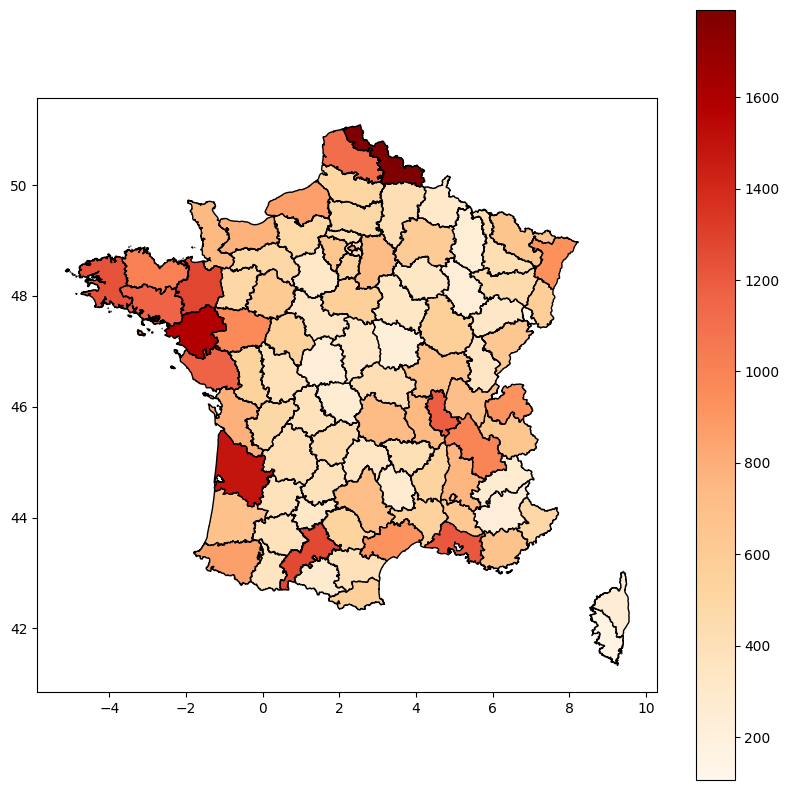

In [149]:
construction_activity2018.plot(
    column=2018,
    cmap="OrRd",
    legend=True,
    figsize=(10, 10),
    edgecolor="black"
) 

#### -> Q1 What's happening in the North ? 

In [171]:
df.loc[
    df["Code du département du lieu des travaux - Code de la zone"] == "44",
    "Destination principale"
].value_counts()


Destination principale
service public ou d'intérêt collectif    3839
agriculture                              3365
habitation                               2432
commerce                                 2017
bureaux                                  2012
entrepôt                                 1873
artisanat                                1371
industrie                                1327
hébergement hôtelier                      298
Name: count, dtype: int64

On peut supposer qu'il y a plusieurs biais dans la base, étant donné que les administrations sont plus susceptibles de signaler des travaux que des acteurs privés, de la même manière l'agriculture code plus fréquemment des modifications de terrains 

### Density of construction

In [ ]:
df.loc[:,col_relevant].head()

,Code de la région du lieu des travaux - Code de la zone,Code de la région du lieu des travaux - Libellé de la zone,Code du département du lieu des travaux - Code de la zone,Code du département du lieu des travaux - Libellé de la zone,Code de la commune du lieu des travaux,Etat d'avancement du projet,Code d'activité principale de l'établissement d'un demandeur avéré en tant que personne morale,Catégorie juridique d'un demandeur avéré en tant que personne morale,Dénomination d'un demandeur avéré en tant que personne morale,Numéro SIREN d'un demandeur avéré en tant que personne morale,...,Nature du projet déclarée par le demandeur,Nature de projet détaillée,Destination principale,Type principal de transformation,Type principal des locaux d'origine transformés,Type de service public ou d'intérêt collectif,Adresse_complete,longitude,latitude,Année de dépôt de la DAU
1,82,Rhône-Alpes,01,Ain,01001,5,01.50Z,6533,GROUPEMENT AGRICOLE D'EXPLOITATION EN COMMUN R...,434449088,...,1,1,7,<NA>,<NA>,7,ABERGEMENT CLEMENCIAT,4.926588,46.151812,2017-01-01
2,82,Rhône-Alpes,01,Ain,01001,2,01.61Z,6316,CUMA DE L'ABERGEMENT CLEMENCIAT,779289941,...,2,5,3,<NA>,<NA>,7,203 Rue des cinq Chemins ABERGEMENT CLEMENCIAT,4.922429,46.152118,2019-01-01
3,82,Rhône-Alpes,01,Ain,01001,5,<NA>,<NA>,<NA>,<NA>,...,1,1,9,<NA>,<NA>,6,172 Route du Chateau ABERGEMENT CLEMENCIAT,4.920218,46.152497,2020-01-01
4,82,Rhône-Alpes,01,Ain,01001,2,<NA>,<NA>,<NA>,<NA>,...,2,5,7,<NA>,<NA>,7,Sur Brody ABERGEMENT CLEMENCIAT,4.915929,46.163314,2019-01-01
5,82,Rhône-Alpes,01,Ain,01001,2,61.10Z,5599,FRANCE TELECOM,380129866,...,1,1,9,<NA>,<NA>,5,LE SORBIER ABERGEMENT CLEMENCIAT,4.927541,46.137953,2020-01-01


In [150]:
df['Geometry'] = df.apply(
    lambda x: Point(x["longitude"], x["latitude"]) 
    if x["longitude"] and x["latitude"] 
    else None,
    axis = 1
)
gdf = gpd.GeoDataFrame(
    df,              # les données
    geometry="Geometry",     # La colonne de géométrie
    crs='EPSG:4326'       # Système de coordonnées WGS84
)



In [179]:
from keplergl import KeplerGl




ModuleNotFoundError: No module named 'keplergl'

In [177]:
m = KeplerGl(height=600)
m.add_data(gdf, "geometry")
m

NameError: name 'KeplerGl' is not defined